**Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
from sklearn.inspection import permutation_importance
import shap


import warnings
warnings.filterwarnings("ignore")

In [2]:
!gdown 1NBk1TFkK4NeKdodR2DxIdBp2Mk1mh4AS

Downloading...
From: https://drive.google.com/uc?id=1NBk1TFkK4NeKdodR2DxIdBp2Mk1mh4AS
To: /content/insurance.csv
100% 30.8k/30.8k [00:00<00:00, 35.2MB/s]


**Storing a dataset into a varibale to perform operations**

In [3]:
data = pd.read_csv('insurance.csv')
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


- There is no missing values in dataset.

In [4]:
# Feature engineering: Create BMI (Body Mass Index) from height and weight
data['BMI'] = data['Weight'] / (data['Height'] / 100)**2

In [5]:
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,45,0,0,0,0,155,57,0,0,0,25000,23.725286
1,60,1,0,0,0,180,73,0,0,0,29000,22.530864
2,36,1,1,0,0,158,59,0,0,1,23000,23.634033
3,52,1,1,0,1,183,93,0,0,2,28000,27.770313
4,38,0,0,0,1,166,88,0,0,1,23000,31.934969


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      986 non-null    int64  
 1   Diabetes                 986 non-null    int64  
 2   BloodPressureProblems    986 non-null    int64  
 3   AnyTransplants           986 non-null    int64  
 4   AnyChronicDiseases       986 non-null    int64  
 5   Height                   986 non-null    int64  
 6   Weight                   986 non-null    int64  
 7   KnownAllergies           986 non-null    int64  
 8   HistoryOfCancerInFamily  986 non-null    int64  
 9   NumberOfMajorSurgeries   986 non-null    int64  
 10  PremiumPrice             986 non-null    int64  
 11  BMI                      986 non-null    float64
dtypes: float64(1), int64(11)
memory usage: 92.6 KB


In [7]:
# Check for missing values
print(data.isnull().sum())

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
BMI                        0
dtype: int64


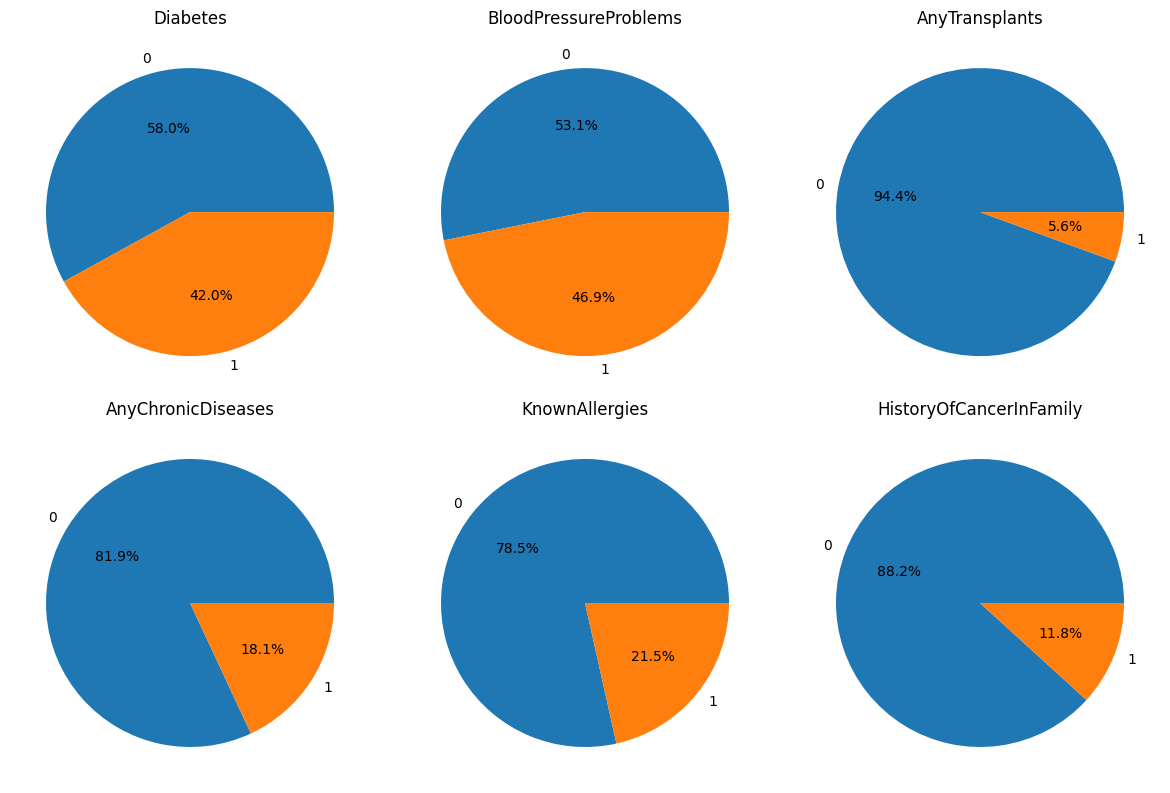

In [8]:
features = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()

for i, col in enumerate(features):
    ax = axes[i]
    x = data[col].value_counts()
    ax.pie(x.values, labels=x.index, autopct='%1.1f%%')
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [9]:
df = data.copy()

**Scaling of numerical features**

In [10]:
scaler = StandardScaler()
numerical_features = ['Age', 'Height', 'Weight', 'NumberOfMajorSurgeries', 'BMI']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [11]:
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,0.233197,0,0,0,0,-1.306105,-1.399250,0,0,-0.891187,25000,-0.635742
1,1.307981,1,0,0,0,1.170852,-0.277062,0,0,-0.891187,29000,-0.839024
2,-0.411674,1,1,0,0,-1.008870,-1.258976,0,0,0.444239,23000,-0.651273
3,0.734763,1,1,0,1,1.468086,1.125674,0,0,1.779665,28000,0.052692
4,-0.268369,0,0,0,1,-0.216244,0.774990,0,0,0.444239,23000,0.761487


### **Train-Test Split**

In [12]:
# Splitting data into training and test sets
X = data.drop(columns=['PremiumPrice'])
# Target variable
y = data['PremiumPrice']

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Train data size:", len(X_train), "\nTest data size:", len(X_test))

# Check processed data
X_train.head()

Train data size: 690 
Test data size: 296


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,BMI
398,1.737895,1,1,0,0,-0.513479,-0.487472,0,0,1.779665,-0.189631
523,-0.483326,0,1,0,0,0.080991,0.634716,0,0,-0.891187,0.451059
809,0.448154,0,0,0,1,-0.711635,1.265947,0,0,0.444239,1.563921
501,-1.128196,0,0,0,1,1.567165,-0.277062,0,0,0.444239,-1.003933
430,1.164677,1,1,0,0,-0.909792,-1.048566,0,0,-0.891187,-0.499748


### **Linear Regression model**

In [13]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# Evaluate
print("Linear Regression Results:")
print("-------------------------------")
print(f"R² Score (Train): {r2_score(y_train, y_pred_lr_train):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_lr_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_lr_train)):.2f}")
print("-------------------------------")
print(f"R² Score (Test): {r2_score(y_test, y_pred_lr_test):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_lr_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr_test)):.2f}")

Linear Regression Results:
-------------------------------
R² Score (Train): 0.6044
Train MAE: 2703.93
Train RMSE: 3817.23
-------------------------------
R² Score (Test): 0.7053
Test MAE: 2639.73
Test RMSE: 3594.27


### **Ridge Regression model**

In [14]:
X_train_scaled = X_train
X_test_scaled = X_test

# Define Ridge Regression model
ridge_model = Ridge()

# Hyperparameter tuning using GridSearchCV
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(ridge_model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best model and hyperparameter
best_ridge = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best R² Score: {grid_search.best_score_}")

# Make predictions
y_pred_train_ridge = best_ridge.predict(X_train_scaled)
y_pred_test_ridge = best_ridge.predict(X_test_scaled)

# Evaluate model
print("\nRidge Regression Results:")
print("-------------------------------")
print(f"R² Score (Train): {r2_score(y_train, y_pred_train_ridge):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_train_ridge):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_ridge)):.2f}")
print("-------------------------------")
print(f"R² Score (Test): {r2_score(y_test, y_pred_test_ridge):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_ridge):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_ridge)):.2f}")

Best alpha: 1
Best R² Score: 0.5853474310410258

Ridge Regression Results:
-------------------------------
R² Score (Train): 0.6043
Train MAE: 2703.31
Train RMSE: 3817.77
-------------------------------
R² Score (Test): 0.7036
Test MAE: 2645.20
Test RMSE: 3605.05


In [15]:
# Splitting data into training and test sets
X = df.drop(columns=['PremiumPrice'])
# Target variable
y = df['PremiumPrice']

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Train data size:", len(X_train), "\nTest data size:", len(X_test))

# Check processed data
X_train.head()

Train data size: 690 
Test data size: 296


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,BMI
398,66,1,1,0,0,163,70,0,0,2,26.346494
523,35,0,1,0,0,169,86,0,0,0,30.110991
809,48,0,0,0,1,161,95,0,0,1,36.649821
501,26,0,0,0,1,184,73,0,0,1,21.561909
430,58,1,1,0,0,159,62,0,0,0,24.524346


### **Decision Tree Model**

In [16]:
# Train Decision Tree
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_dt_train = dt_model.predict(X_train)
y_pred_dt_test = dt_model.predict(X_test)

print("Decision Tree Results:")
print("-------------------------------")
print(f"R² Score (Train): {r2_score(y_train, y_pred_dt_train):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_dt_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_dt_train)):.2f}")
print("-------------------------------")
print(f"R² Score (Test): {r2_score(y_test, y_pred_dt_test):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_dt_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt_test)):.2f}")

Decision Tree Results:
-------------------------------
R² Score (Train): 0.8245
Train MAE: 1237.44
Train RMSE: 2542.48
-------------------------------
R² Score (Test): 0.6793
Test MAE: 1644.01
Test RMSE: 3749.76


### **Random Forest Model**

In [17]:
# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

print("Random Forest Results:")
print("-------------------------------")
print(f"R² Score (Train): {r2_score(y_train, y_pred_rf_train):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_rf_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_rf_train)):.2f}")
print("-------------------------------")
print(f"R² Score (Test): {r2_score(y_test, y_pred_rf_test):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_rf_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_test)):.2f}")
print("________________________________")

# Feature Importance
print("Feature Importance:")
print("-------------------------------")
importances = rf_model.feature_importances_
for i, feature in enumerate(X.columns):
    print(f"{feature}: {importances[i]:.4f}")

Random Forest Results:
-------------------------------
R² Score (Train): 0.9640
Train MAE: 485.59
Train RMSE: 1151.65
-------------------------------
R² Score (Test): 0.8418
Test MAE: 1211.93
Test RMSE: 2633.90
________________________________
Feature Importance:
-------------------------------
Age: 0.6112
Diabetes: 0.0047
BloodPressureProblems: 0.0089
AnyTransplants: 0.0879
AnyChronicDiseases: 0.0430
Height: 0.0341
Weight: 0.1035
KnownAllergies: 0.0024
HistoryOfCancerInFamily: 0.0225
NumberOfMajorSurgeries: 0.0301
BMI: 0.0516


### **Random Forest Model with GridSearchCV**

In [18]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

# Best parameters and performance
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Cross-Validation R² Score:", grid_search.best_score_)

# Evaluate the best model on the test set
y_pred_rf_test = best_model.predict(X_test)
print("-------------------------------")
print(f"Test R² Score: {r2_score(y_test, y_pred_rf_test):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_rf_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_test)):.2f}")

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation R² Score: 0.7062723703840563
-------------------------------
Test R² Score: 0.7887
Test MAE: 1990.35
Test RMSE: 3043.46


### **Random Forest Model with Hyperparameter Tuning**

In [19]:
# Train Random Forest
rf_model = RandomForestRegressor(max_depth = 10, min_samples_split = 10, min_samples_leaf = 2, n_estimators = 200)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

print("Random Forest Results:")
print("-------------------------------")
print(f"R² Score (Train): {r2_score(y_train, y_pred_rf_train):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_rf_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_rf_train)):.2f}")
print("-------------------------------")
print(f"R² Score (Test): {r2_score(y_test, y_pred_rf_test):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_rf_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf_test)):.2f}")

Random Forest Results:
-------------------------------
R² Score (Train): 0.8727
Train MAE: 900.22
Train RMSE: 2165.04
-------------------------------
R² Score (Test): 0.8775
Test MAE: 1099.30
Test RMSE: 2317.51


### **XGBoost Model**

In [20]:
# Train Extreme Gradient Boosting Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)
print("XGBoost Results:")
print("-------------------------------")
print(f"R² Score (Train): {r2_score(y_train, y_pred_xgb_train):.4f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_pred_xgb_train):.2f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_xgb_train)):.2f}")
print("-------------------------------")
print(f"R² Score (Test): {r2_score(y_test, y_pred_xgb_test):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_xgb_test):.2f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_test)):.2f}")

XGBoost Results:
-------------------------------
R² Score (Train): 0.9745
Train MAE: 549.69
Train RMSE: 969.43
-------------------------------
R² Score (Test): 0.8040
Test MAE: 1412.68
Test RMSE: 2931.49


### **Model Comparison**

In [21]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Placeholder for model results
results = []

# Function to evaluate and store model performance
def evaluate_model(name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # Calculate MSE and then RMSE to avoid the 'squared' argument issue
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append({'Model': name, 'R² Score': r2, 'MAE': mae, 'RMSE': rmse})

# Linear Regression
evaluate_model('Linear Regression', y_test, y_pred_lr_test)

# Ridge Regression
evaluate_model('Ridge Regression', y_test, y_pred_test_ridge)

# Decision Tree
evaluate_model('Decision Tree', y_test, y_pred_dt_test)

# Random Forest
evaluate_model('Random Forest', y_test, y_pred_rf_test)

# XGBoost
evaluate_model('XGBoost', y_test, y_pred_xgb_test)

# Convert results to DataFrame
summary_table = pd.DataFrame(results)

# Display summary table
summary_table = summary_table.sort_values(by='R² Score', ascending=False)
summary_table

,Model,R² Score,MAE,RMSE
3,Random Forest,0.877500,1099.297287,2317.512433
4,XGBoost,0.803993,1412.676636,2931.491941
0,Linear Regression,0.705344,2639.726744,3594.274581
1,Ridge Regression,0.703574,2645.200355,3605.052604
2,Decision Tree,0.679299,1644.006056,3749.761986


- Random Forest is the best model overall in terms of R², MAE, and RMSE, making it the most effective at capturing the variance in data.
- XGBoost, while a strong model, doesn't quite match the performance of Random Forest here. However, it can still be useful in certain contexts or for further fine-tuning.
- Linear and Ridge Regression models perform poorly with relatively high error rates, indicating that a more complex model (like Random Forest) is needed to capture the underlying patterns in the data.
- Decision Tree might benefit from hyperparameter tuning (e.g., pruning) to improve generalization.

### **Model Selection for Prediction**

In [22]:
import pickle

# Save the model to a file
final_model_filename = 'final_predict_model.pkl'
with open(final_model_filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model saved to {final_model_filename}")

Model saved to final_predict_model.pkl


In [23]:
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Displaying feature importances
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature  Importance
0                       Age    1.098452
3            AnyTransplants    0.246584
6                    Weight    0.099698
4        AnyChronicDiseases    0.065862
8   HistoryOfCancerInFamily    0.042063
9    NumberOfMajorSurgeries    0.038762
2     BloodPressureProblems    0.011699
10                      BMI    0.008101
5                    Height    0.000039
7            KnownAllergies   -0.000119
1                  Diabetes   -0.000180


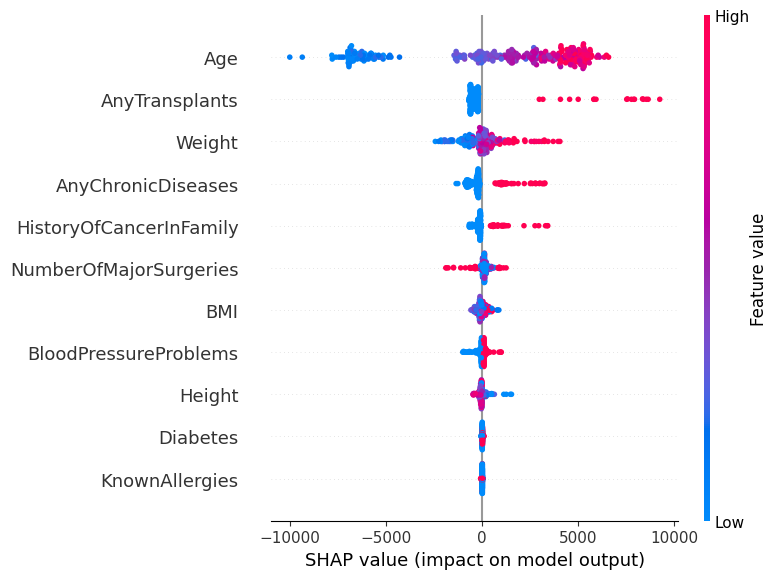

In [24]:
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# Plotting SHAP summary plot for global feature importance
shap.summary_plot(shap_values, X_test)

### **Generate New Data**

In [25]:
np.random.seed(42)

n_samples = 1000

# Age: Numeric, ranging from 18 to 66 years.
age = np.random.randint(18, 67, n_samples)

# Diabetes: Binary (0 or 1).
diabetes = np.random.randint(0, 2, n_samples)

# BloodPressureProblems: Binary (0 or 1).
blood_pressure_problems = np.random.randint(0, 2, n_samples)

# AnyTransplants: Binary (0 or 1).
any_transplants = np.random.randint(0, 2, n_samples)

# AnyChronicDiseases: Binary (0 or 1).
any_chronic_diseases = np.random.randint(0, 2, n_samples)

# Height: Numeric, measured in centimeters, ranging from 145 cm to 188 cm.
height = np.random.randint(145, 189, n_samples)

# Weight: Numeric, measured in kilograms, ranging from 51 kg to 132 kg.
weight = np.random.randint(51, 133, n_samples)

# KnownAllergies: Binary (0 or 1).
known_allergies = np.random.randint(0, 2, n_samples)

# HistoryOfCancerInFamily: Binary (0 or 1).
history_of_cancer_in_family = np.random.randint(0, 2, n_samples)

# NumberOfMajorSurgeries: Numeric, counting the number of major surgeries, ranging from 0 to 3 surgeries.
number_of_major_surgeries = np.random.randint(0, 4, n_samples)

# PremiumPrice: Numeric, representing the premium price in currency, ranging from 15,000 to 40,000.
premium_price = np.random.randint(15000, 40001, n_samples)

# Calculate BMI (Body Mass Index) from height and weight
bmi = weight / (height / 100) ** 2

# Create a DataFrame with all the features
new_data = pd.DataFrame({
    'Age': age,
    'Diabetes': diabetes,
    'BloodPressureProblems': blood_pressure_problems,
    'AnyTransplants': any_transplants,
    'AnyChronicDiseases': any_chronic_diseases,
    'Height': height,
    'Weight': weight,
    'KnownAllergies': known_allergies,
    'HistoryOfCancerInFamily': history_of_cancer_in_family,
    'NumberOfMajorSurgeries': number_of_major_surgeries,
    'PremiumPrice': premium_price,
    'BMI': bmi
})

# Show a sample of the data
new_data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,BMI
0,56,0,1,0,0,165,119,1,1,0,22169,43.709826
1,46,1,1,1,1,187,60,0,1,1,28288,17.158054
2,32,1,0,1,0,179,75,1,1,2,37398,23.407509
3,60,0,0,0,0,157,118,0,0,2,25694,47.872125
4,25,1,1,0,1,154,111,0,0,1,27191,46.803846


In [26]:
new_data.shape

(1000, 12)

In [27]:
# Splitting data into training and test sets
X_new = new_data.drop(columns=['PremiumPrice'])
# Target variable
y_new = new_data['PremiumPrice']

# Train-Test Split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Train data size:", len(X_train), "\nTest data size:", len(X_test))

# Check processed data
X_train.head()

Train data size: 690 
Test data size: 296


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,BMI
398,66,1,1,0,0,163,70,0,0,2,26.346494
523,35,0,1,0,0,169,86,0,0,0,30.110991
809,48,0,0,0,1,161,95,0,0,1,36.649821
501,26,0,0,0,1,184,73,0,0,1,21.561909
430,58,1,1,0,0,159,62,0,0,0,24.524346


In [ ]:
# Load the trained XGBoost model
model = joblib.load('final_predict_model.pkl')

In [28]:
# Compute permutation importance
result = permutation_importance(rf_model, X_new, y_new, n_repeats=10, random_state=42, n_jobs=-1)

# Display feature importances
importance_df = pd.DataFrame({
    'Feature': X_new.columns,
    'Importance': result.importances_mean
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature  Importance
3            AnyTransplants    0.030049
0                       Age    0.011431
4        AnyChronicDiseases    0.009122
7            KnownAllergies    0.000200
1                  Diabetes   -0.000063
8   HistoryOfCancerInFamily   -0.004115
5                    Height   -0.007259
2     BloodPressureProblems   -0.011806
6                    Weight   -0.016142
9    NumberOfMajorSurgeries   -0.017357
10                      BMI   -0.023545


 99%|===================| 994/1000 [00:16<00:00]       

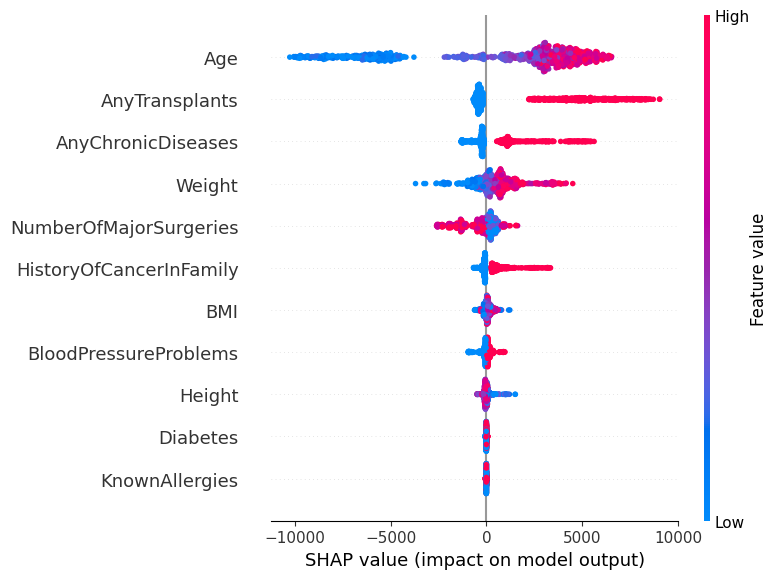

In [29]:
# Create an explainer using SHAP
explainer = shap.Explainer(rf_model, X_train)  # X_train is used to fit the explainer

# Get SHAP values for the new data
shap_values = explainer(X_new)

# Plot the SHAP values to explain the prediction
shap.summary_plot(shap_values, X_new)